# DAT550 Project presentation

Asahi Cantu Moreno
Aman Riaz

# 1.- Package installation

In [1]:
!pip install pyarrow
!pip install numpy
!pip install pandas
!pip install tqdm
!pip install spacy
!pip install orca
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


# Modules

In [2]:
import os


import numpy as np
import pandas as pd
import json 
import multiprocessing as mp
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import re
from pandas import Panel
tqdm.pandas()

import gc
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<ipython-input-2-6fa6b938f649>:14: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
c:\python\382\lib\site-packages\tqdm\std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
unable to import 'smart_open.gcs', disabling that module
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
os.getcwd()

'c:\\Covid\\DAT550'

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
class Stats:
    def __init__(self,elapsed_time=0, items=0):
        self.elapsed_time = elapsed_time
        self.items= items
        
    def add(self,stats):
        self.elapsed_time += stats.elapsed_time
        self.items= +stats.items
        
    def to_string(self):
        return f'Elapsed time: {self.elapsed_time} - Items:{self.items}'
    
    def __str__(self):
        return self.to_string()
        
    def __repr__(self):
         return self.to_string()
            
    def __add__(self, o): 
        et = self.elapsed_time + o.elapsed_time
        it = self.items + o.items
        return Stats(et,it) 
    
    def __iadd__(self, o): 
        self.elapsed_time += o.elapsed_time
        self.items += o.items
        return self
    
        
def load_json_files(documents,directory_name):
    articles = {}
    
    articlenames = os.listdir(directory_name)
    pbar = tqdm(articlenames)
    pbar.set_description(f'Loading files from {directory_name}')
    for articlename in pbar:
        article_path = os.path.join(directory_name,articlename)
        if os.path.isdir(article_path):
            load_json_files(documents,article_path)
            continue
            
        filename = os.path.basename(articlename)
        filename = os.path.splitext(filename)[0]
        if filename not in documents:
            continue
            
        article = json.load(open(article_path, 'rb'))
        articles[filename] = article
        
    elapsed_time = pbar.format_dict['elapsed']
    items = pbar.format_dict['total']
    stats = Stats(elapsed_time,items)
    return stats, articles

def try_get_val(dictionary,dict_key):
    if dict_key in dictionary:
        return dictionary[dict_key]
    return None

def parse_collection(val):
    if val is not None:
        t_val = type(val)
        if t_val == tuple or  t_val == list:
            return ' '.join(val)
    return val

'''
Parse Json giles into a human -readable forman
'''
def load_json_article(article):
    paper_id = try_get_val(article,'paper_id')
    metadata = try_get_val(article,'metadata')
    title = try_get_val(article,'title')
    #source = article["source"]
    
    authors = []
    art_metadata = article['metadata']
    if 'authors' in art_metadata:
        for author in art_metadata['authors']:
            auth = {
            'paper_id' : paper_id,
            'full_name': '',
            'first' : author['first'],
            'middle': ' '.join(author['middle']),
            'last' : author['last'],
            'email' : author ['email'],
            'laboratory' : None,
            'institution' : None,
            'settlement' : None,
            'region' : None,
            'country' : None,
            'postCode' : None,
            }
            
            if 'affiliation' in author:
                afiliation = author['affiliation']
                auth['laboratory'] =  try_get_val(afiliation,'laboratory')
                auth['institution'] =  try_get_val(afiliation,'institution')
                if 'location' in  afiliation:
                    location = afiliation['location']
                    auth['settlement'] =  try_get_val(location,'settlement')
                    auth['region'] = try_get_val(location,'region')
                    auth['country'] = try_get_val(location,'country')
                    auth['postCode'] = try_get_val(location,'postCode')
            auth['full_name'] = auth['first'] + ' ' + auth['middle'] + ' ' + auth['last']
            
            authors.append(auth)

    body = []
    abstracts = []
    if 'body_text' in article:
        for bod in article["body_text"]:
            body.append(bod["text"])

    if 'abstract' in article:
        abstracts = [a['text'] for a in article["abstract"]]

    #"source" : source,
    art = {
        "paper_id" : paper_id,
        "title" : title,
        "abstract" : ' '.join(abstracts) ,
        "body" : ' '.join(body)
        
    }
    return art, authors 
    

def write_pickle(obj,file_name):
    file = open(file_name,'wb')
    pickle.dump(obj,file)
    file.close()
    
def read_pickle(file_name):
    obj = None
    if os.path.isfile(file_name):
        file = open(file_name,'rb')
        obj = pickle.load(file)
        file.close()
    return obj

def try_read_parquet(file_name):
    if os.path.isfile(file_name):
        return pd.read_parquet(file_name)
    return None
    

'\nParse Json giles into a human -readable forman\n'

Loading metadata

In [6]:
path = '..\\CORD-19-research-challenge'
data_dirs = [
    'biorxiv_medrxiv\\biorxiv_medrxiv\\pdf_json'
    ,'comm_use_subset\\comm_use_subset\\pdf_json'
    ,'custom_license\\custom_license\\pdf_json'
    ,'noncomm_use_subset\\noncomm_use_subset\\pdf_json'
]
metadata_file = 'metadata.csv'

In [7]:
meta_df = pd.read_csv(os.path.join(path,metadata_file), dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})

meta_df = meta_df[meta_df['sha'].notna()]

In [8]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38022 entries, 0 to 51076
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   cord_uid                     38022 non-null  object
 1   sha                          38022 non-null  object
 2   source_x                     38022 non-null  object
 3   title                        37986 non-null  object
 4   doi                          37683 non-null  object
 5   pmcid                        31205 non-null  object
 6   pubmed_id                    28962 non-null  object
 7   license                      38022 non-null  object
 8   abstract                     33570 non-null  object
 9   publish_time                 38022 non-null  object
 10  authors                      37422 non-null  object
 11  journal                      36289 non-null  object
 12  Microsoft Academic Paper ID  419 non-null    object
 13  WHO #Covidence               60

Preprocessing, droping duplicates

In [9]:
meta_df.drop_duplicates(['abstract','authors'], inplace=True)
meta_df['abstract'].describe(include='all')

count       33501
unique      33467
top       Unknown
freq           20
Name: abstract, dtype: object

In [10]:
meta_df.describe()

cord_uid                                       sha source_x  \
count      37273                                     37273    37273   
unique     37264                                     37261        5   
top     6z5f2gz3  4644c32551fb23aa873a7738ecc8d777bd49877e      PMC   
freq           2                                         4    20000   

                      title                            doi       pmcid  \
count                 37270                          36957       30930   
unique                37023                          36952       30930   
top     Infectious Diseases  10.1097/jcma.0000000000000270  PMC7112690   
freq                      6                              2           1   

       pubmed_id    license abstract publish_time           authors   journal  \
count      28774      37273    33501        37273             37115     35548   
unique     28767         13    33467         5676             36205      5461   
top     15161626  els-covid  Unknown   2016-12-31  Domingo, Esteban  PLoS One   
freq           2      15545       20          244                14      1564   

       Microsoft Academic Paper ID WHO #Covidence has_pdf_parse  \
count                          413            595         37273   
unique                         344            595             1   
top                     3006645647             #8          True   
freq                            10              1         37273   

       has_pmc_xml_parse  full_text_file  \
count              37273           37273   
unique                 2               4   
top                False  custom_license   
freq               19092           24488   

                                                  url  
count                                           37272  
unique                                          37271  
top     https://doi.org/10.1097/jcma.0000000000000270  
freq                                                2

In [11]:
meta_df

cord_uid                                       sha  source_x  \
0      xqhn0vbp  1e1286db212100993d03cc22374b624f7caee956       PMC   
1      gi6uaa83  8ae137c8da1607b3a8e4c946c07ca8bda67f88ac       PMC   
3      fy4w7xz8  0104f6ceccf92ae8567a0102f89cbb976969a774       PMC   
4      0qaoam29  5b68a553a7cbbea13472721cd1ad617d42b40c26       PMC   
5      qj4dh6rg  3ed670f60a7be2e3e2a991ea8af1fdd5fa5e2b2c       PMC   
...         ...                                       ...       ...   
51071  5zmgvlj9  f3b4724163d8a42bc2788547d18f2521e14c44a1  Elsevier   
51072  6lh4jsor  93244303c6041ad53fcc59cc06a03cc51621edcc  Elsevier   
51073  4xhcamks  e14e7f6ffed1a74954167e4fb52d1b2f156171cd  Elsevier   
51075  wncuc903  2b3a3e3956afd65a8fa11d3867da3e58f8915514  Elsevier   
51076  4x1ckr2i  a67dae6e5f2b58a6f16aaed4011c694f9e64dd88  Elsevier   

                                                   title  \
0      Airborne rhinovirus detection and effect of ul...   
1        Discovering human history from stomach bacteria   
3      Association of HLA class I with severe acute r...   
4       A double epidemic model for the SARS propagation   
5      Cloaked similarity between HIV-1 and SARS-CoV ...   
...                                                  ...   
51071    Health Care–Acquired Viral Respiratory Diseases   
51072  NIAID resources for developing new therapies f...   
51073  Prevalence of antibodies against transmissible...   
51075  Fast degrading polyesters as siRNA nano-carrie...   
51076  eIF3f: A central regulator of the antagonism a...   

                                   doi       pmcid pubmed_id    license  \
0                10.1186/1471-2458-3-5   PMC140314  12525263      no-cc   
1              10.1186/gb-2003-4-5-213   PMC156578  12734001      no-cc   
3                10.1186/1471-2350-4-9   PMC212558  12969506      no-cc   
4               10.1186/1471-2334-3-19   PMC222908  12964944      no-cc   
5               10.1186/1471-2180-3-20   PMC222911  14499001      no-cc   
...                                ...         ...       ...        ...   
51071        10.1016/j.idc.2016.07.004  PMC7125527  27816139  els-covid   
51072  10.1016/j.antiviral.2007.10.006  PMC7132394  18061283  els-covid   
51073        10.1016/j.vas.2018.11.003  PMC7104163       NaN  els-covid   
51075    10.1016/j.jconrel.2008.06.010  PMC7125568  18619502  els-covid   
51076     10.1016/j.biocel.2013.06.001  PMC7108353  23769948  els-covid   

                                                abstract publish_time  \
0      BACKGROUND: Rhinovirus, the most common cause ...   2003-01-13   
1      Recent analyses of human pathogens have reveal...   2003-04-28   
3      BACKGROUND: The human leukocyte antigen (HLA) ...   2003-09-12   
4      BACKGROUND: An epidemic of a Severe Acute Resp...   2003-09-10   
5      BACKGROUND: Severe acute respiratory syndrome ...   2003-09-21   
...                                                  ...          ...   
51071  Health care–acquired viral respiratory infecti...   2016-12-31   
51072  Abstract Severe viral infections, including he...   2008-04-30   
51073  Abstract Transmissible gastroenteritis (TGE) i...   2019-06-30   
51075  Abstract A potential siRNA carrier for pulmona...   2008-12-18   
51076  Abstract The eukaryotic initiation factor 3 su...   2013-10-31   

                                                 authors  \
0      Myatt, Theodore A; Johnston, Sebastian L; Rudn...   
1                                       Disotell, Todd R   
3      Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...   
4      Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine   
5                        Kliger, Yossef; Levanon, Erez Y   
...                                                  ...   
51071                   Dare, Ryan K.; Talbot, Thomas R.   
51072  Greenstone, Heather; Spinelli, Beth; Tseng, Ch...   
51073  Valkó, Anna; Bálint, Ádám; Bozsa, Ágnes; Cságo...   
51075  Nguyen, Juliane; Steele, Terry W.J.; Merkel, O..

Document sha reconstruction into a list to create an index that help iterate through the extracted json documents

In [12]:
documents = meta_df.sha.to_list()
docs = []
for doc in documents:
    splits = doc.split(';') # Documents that contain more than to sha's have to be parsed
    for split in splits:
        docs.append(split.strip())

Stage 1 - Data Loading process, getting all json files based on shas headers and saving them into pickle file,

In [13]:
pickle_file_name = 'json_data.pickle'
articles_set = read_pickle(pickle_file_name)
#articles_set = None
if articles_set is None:
    articles_set = {}
    stats = Stats()
    documents = meta_df.sha.to_list()
    for data_dir in data_dirs:
        st , articles = load_json_files(docs,os.path.join(path,data_dir))
        articles_set.update(articles) 
        stats += st
    print('Writing Pickle....')
    write_pickle(articles_set, pickle_file_name)


### Stage 2.- Document set transformation into pandas data frame. DataFrames are later on saved into parquet

### Try read parquet data for processed articles and authors, if not available will re-run the parsing process

In [14]:
authors_file = 'authors.parquet'
articles_file = 'articles.parquet'

authors = try_read_parquet(authors_file)
articles = try_read_parquet(articles_file)
if authors is None or articles is None:
    authors = pd.DataFrame()
    articles = pd.DataFrame()
    for key in tqdm(articles_set):
        article, auths = load_json_article(articles_set[key])
        articles = articles.append(article,ignore_index=True)
        authors= authors.append(pd.DataFrame(auths),ignore_index=True)
    authors.to_parquet(authors_file)
    articles.to_parquet(articles_file)
        
    

In [15]:
documents = None
articles_set = None
docs = None
documents = None
gc.collect()

28

### Stage 3 - Data Preprocessing Now process the authors so we habe better insights where the paper publications are comming from

In [16]:
authors

paper_id             full_name  \
0       0015023cc06b5362d332b3baf348d11567ca2fbb         Joseph C Ward   
1       0015023cc06b5362d332b3baf348d11567ca2fbb  Lidia  Lasecka-Dykes   
2       0015023cc06b5362d332b3baf348d11567ca2fbb           Chris  Neil   
3       0015023cc06b5362d332b3baf348d11567ca2fbb  Oluwapelumi  Adeyemi   
4       0015023cc06b5362d332b3baf348d11567ca2fbb               Sarah     
...                                          ...                   ...   
232689  ffed5d2a31a0c1a0db11905fe378e7735b6d70ca         Alon  Diament   
232690  ffed5d2a31a0c1a0db11905fe378e7735b6d70ca         Tamir  Tuller   
232691  ffed5d2a31a0c1a0db11905fe378e7735b6d70ca       Ramat  Hachayal   
232692  ffed5d2a31a0c1a0db11905fe378e7735b6d70ca             Tel  Aviv   
232693  ffed5d2a31a0c1a0db11905fe378e7735b6d70ca              Israel     

              first middle           last email laboratory  \
0            Joseph      C           Ward             None   
1             Lidia         Lasecka-Dykes             None   
2             Chris                  Neil             None   
3       Oluwapelumi               Adeyemi             None   
4             Sarah                                   None   
...             ...    ...            ...   ...        ...   
232689         Alon               Diament                    
232690        Tamir                Tuller                    
232691        Ramat              Hachayal             None   
232692          Tel                  Aviv             None   
232693       Israel                                   None   

                institution settlement region country postCode  
0                      None       None   None    None     None  
1                      None       None   None    None     None  
2                      None       None   None    None     None  
3                      None       None   None    None     None  
4                      None       None   None    None     None  
...                     ...        ...    ...     ...      ...  
232689  Tel-Aviv University       None   None  Israel     None  
232690  Tel-Aviv University       None   None  Israel     None  
232691                 None       None   None    None     None  
232692                 None       None   None    None     None  
232693                 None       None   None    None     None  

[232694 rows x 12 columns]

In [17]:
articles

abstract  \
0      word count: 194 22 Text word count: 5168 23 24...   
1      During the past three months, a new coronaviru...   
2                                                          
3      The fast accumulation of viral metagenomic dat...   
4      Infectious bronchitis (IB) causes significant ...   
...                                                  ...   
39384  Even though coronavirus infection of humans is...   
39385  There is extensive evidence that cultured macr...   
39386  We have combined in vivo and in vitro approach...   
39387  We provide experimental evidence of a replicat...   
39388  Israel. *Corresponding author (TT): tamirtul@p...   

                                                    body  \
0      VP3, and VP0 (which is further processed to VP...   
1      In December 2019, a novel coronavirus, SARS-Co...   
2      The 2019-nCoV epidemic has spread across China...   
3      Metagenomic sequencing, which allows us to dir...   
4      Infectious bronchitis (IB), which is caused by...   
...                                                  ...   
39384  Regardless of geographic location, respiratory...   
39385  Experiments were designed to test whether subs...   
39386  can function in an autonomous fashion, relocat...   
39387  Tick-borne encephalitis virus (TBEV) is a huma...   
39388  20min). We trimmed the poly-A adaptors from th...   

                                       paper_id title  
0      0015023cc06b5362d332b3baf348d11567ca2fbb  None  
1      00340eea543336d54adda18236424de6a5e91c9d  None  
2      004f0f8bb66cf446678dc13cf2701feec4f36d76  None  
3      00911cf4f99a3d5ae5e5b787675646a743574496  None  
4      00d16927588fb04d4be0e6b269fc02f0d3c2aa7b  None  
...                                         ...   ...  
39384  ff5a79ed22ea416e6d89caad1cf0d83dbc741a4b  None  
39385  ff6d57f2aad99be129432058665b361dc18747e8  None  
39386  ff83907653a4c4500e8c509ca28169e924742b40  None  
39387  ffe718db1820f27bf274e3fc519ab78e450de288  None  
39388  ffed5d2a31a0c1a0db11905fe378e7735b6d70ca  None  

[39389 rows x 4 columns]

### Get information of the authors (countries)

In [18]:
non_countries = {
    'alabama':'US',
    'belgique':'US',
    'brasil':'BR',
    'britis': 'GB',
    'bosnia':'BA',
    'britain':'GB',
    'california':'US',
    'cameroun':'CM',
    'carolina':'US',
    'czech':'CZ',
    'china':'CN',
    'england':'GB',
    'espagne':'ES',
    'f r g':'DE',
    'frg': 'DE',
    'german research':'DE',
    'hawaii':'US',
    'king saud':'SA',
    'korea':'KR',
    'ital':'IT',
    'iowa':'US',
    'espana':'ES',
    'iran':'IR',
    'iran article info':'IR',
    'iran iran':'IR',
    'kelantan':'MY',
    'ljsa':'GB',
    'macedonia':'MK',
    'maryland':'US',
    'missouri':'US',
    'nether':'NL',
    'oregon':'US',
    'palestine':'PS',
    'pennsylvania':'US',  
    'pereda':'ES',
    'pok':'PK',
    'prc':'CN',
    'roc': 'TW',
    'rsa': 'ZA',
    'reunion island':'FR',
    'syria':'SY',
    'scotland':'GB',
    'slovak': 'SK',
    'south dustralia':'AU',
    'tehran iran':'IR',
    'tunis':'TN',
    'tx':'US',
    'u k':'GB',
    'u s a':'US',
    'uae':'AE',
    'uk':'GB',
    'ulsan':'KR',
    'united':'US',
    'united  states':'US',
    'united arab':'AE',
    'united arab uae':'AE',
    'unites states':'US',
    'universitd debordeaux il':'FR',
    'ucblecnrs':'FR',
    'usa':'US',
    'us':'US',
    'ussr':'RU',
    'umr':'US', #University of Minnesota
    'ut':'US',
    'utah':'US',
    'wales uk':'GB',
    'wpg uk': 'GB',
    'xinjiang uyghur':'CN',
    'aland islands':'FI'}

In [19]:
!pip install pycountry

In [20]:
import pycountry as pc
countries  = list(pc.countries) # Get list of oficcial countries
countries_dict = {c.alpha_2: c.common_name if hasattr(c,'common_name') else c.name for c in pc.countries }
def  parse_countries(country, official_ctries,non_countries):
    if country != None :
        country = country.strip().lower()
        country = pc.remove_accents(country) # Remove accesnts by finding the closest ASCII equivalent
        country = re.sub(r'[0-9]+|\.|;|\(|\)|\+|\?|,', '', country)
        country = re.sub(r'\s\s+', ' ', country)
        for cty in non_countries:
            if cty in country:
                a2 = non_countries[cty]
                a3 = pc.countries.get(alpha_2=a2).alpha_3
                return (a2,a3)
        for oc in official_ctries:
            oc_name = oc.name.lower()
            oc_common_name = oc_name
            if hasattr(oc,'common_name'):
                oc_common_name =  oc.common_name.lower()
            #country = country.capitalize().replace('.','')
            if oc.name in country or \
                oc_common_name in country:
                return (oc.alpha_2, oc.alpha_3)
    return (country,None)

In [21]:
authors_papers = authors[['paper_id','full_name']]
authors_unique = authors.drop(columns=['paper_id'])
authors_unique =  authors_unique.drop_duplicates()
unique_countries = authors_unique.country.unique()

unique_countries_dict = {x:parse_countries(x,countries,non_countries) for x in unique_countries }
authors_unique['country_code_alpha2'] = authors_unique.country.progress_apply(lambda x: unique_countries_dict[x][0] if x != None else 'Unknown' )
authors_unique['country_code_alpha3'] = authors_unique.country.progress_apply(lambda x: unique_countries_dict[x][1] if x != None else 'Unknown' )
authors_unique['country'] = authors_unique['country_code_alpha2'].progress_apply(lambda x: countries_dict[x] if x in countries_dict  else x)
unique_countries = authors_unique.country.unique()
unique_countries.sort()

In [22]:
authors_unique

full_name        first middle           last email  \
0              Joseph C Ward       Joseph      C           Ward         
1       Lidia  Lasecka-Dykes        Lidia         Lasecka-Dykes         
2                Chris  Neil        Chris                  Neil         
3       Oluwapelumi  Adeyemi  Oluwapelumi               Adeyemi         
4                    Sarah          Sarah                               
...                      ...          ...    ...            ...   ...   
232682             D J Evans            D      J          Evans         
232684             I M Jones            I      M          Jones         
232685             E A Gould            E      A          Gould         
232686           T S Gritsun            T      S        Gritsun         
232691       Ramat  Hachayal        Ramat              Hachayal         

       laboratory            institution             settlement region  \
0            None                   None                   None   None   
1            None                   None                   None   None   
2            None                   None                   None   None   
3            None                   None                   None   None   
4            None                   None                   None   None   
...           ...                    ...                    ...    ...   
232682             University of Warwick               Coventry   None   
232684             University of Reading  Whiteknights, Reading   None   
232685                    Bd Jean Moulin              Marseille   None   
232686             University of Reading  Whiteknights, Reading   None   
232691       None                   None                   None   None   

               country         postCode country_code_alpha2  \
0              Unknown             None             Unknown   
1              Unknown             None             Unknown   
2              Unknown             None             Unknown   
3              Unknown             None             Unknown   
4              Unknown             None             Unknown   
...                ...              ...                 ...   
232682         Unknown          CV4 7AL             Unknown   
232684  United Kingdom          RG6 6AJ                  GB   
232685          France  13385, Cedex 05                  FR   
232686  United Kingdom          RG6 6AJ                  GB   
232691         Unknown             None             Unknown   

       country_code_alpha3  
0                  Unknown  
1                  Unknown  
2                  Unknown  
3                  Unknown  
4                  Unknown  
...                    ...  
232682             Unknown  
232684                 GBR  
232685                 FRA  
232686                 GBR  
232691             Unknown  

[197643 rows x 13 columns]

In [23]:
by_country = authors_unique[['country','country_code_alpha3','country_code_alpha2','full_name']].groupby(['country','country_code_alpha3','country_code_alpha2'])
by_country = by_country.count().reset_index()
bc = by_country.sort_values('full_name', ascending=False)
bc=bc.rename(columns={'full_name':'total_publications'})
total_publications = bc.total_publications.sum()
bc = bc[ (bc.country != 'Unknown')]
pubs_by_country = bc.total_publications.sum()

In [24]:
bc

country country_code_alpha3 country_code_alpha2  \
125   United States                 USA                  US   
23            China                 CHN                  CN   
35           France                 FRA                  FR   
124  United Kingdom                 GBR                  GB   
20           Canada                 CAN                  CA   
..              ...                 ...                 ...   
64         Kiribati                 KIR                  KI   
67       Kyrgyzstan                 KGZ                  KG   
83          Myanmar                 MMR                  MM   
87    New Caledonia                 NCL                  NC   
43       Guadeloupe                 GLP                  GP   

     total_publications  
125               29330  
23                25148  
35                 4157  
124                4115  
20                 4055  
..                  ...  
64                    1  
67                    1  
83                    1  
87                    1  
43                    1  

[131 rows x 4 columns]

In [30]:
import plotly.express as px
fig = px.scatter_geo(bc,title=f"Overview of total number of papers issued by country ({pubs_by_country} from {total_publications})", 
                     locations="country_code_alpha3", color="country", hover_name="country", size="total_publications",projection="natural earth")
fig.show()
#IMPORTANT: Requires npm electron orca  to be installed  [ npm install -g electron@6.1.4 orca]
# once installed run [ orca serve -p 63868 --plotly ]
fig.write_image("images\\Articles_overview.png")

### <font color="red"> Cleaning memory to allocate more RAM</font>

In [31]:
articles_set = None
by_country = None
bc = None
gc.collect()

60002

### Now Process the whole article set

In [32]:
articles = try_read_parquet(articles_file)

In [33]:
articles.drop(columns=['title'],inplace=True)
articles.drop_duplicates(['abstract', 'body'], inplace=True)
articles.dropna(inplace=True)

In [34]:
articles.describe()

abstract                                               body  \
count     38915                                              38915   
unique    28497                                              38890   
top              The novel severe acute respiratory syndrome (S...   
freq      10149                                                  2   

                                        paper_id  
count                                      38915  
unique                                     38915  
top     e1453bea78424afaa6fd66d773da792ab8980f3a  
freq                                           1

Removing punctuation marks and setting word counts and lower case letters

In [35]:
articles.body

0        VP3, and VP0 (which is further processed to VP...
1        In December 2019, a novel coronavirus, SARS-Co...
2        The 2019-nCoV epidemic has spread across China...
3        Metagenomic sequencing, which allows us to dir...
4        Infectious bronchitis (IB), which is caused by...
                               ...                        
39384    Regardless of geographic location, respiratory...
39385    Experiments were designed to test whether subs...
39386    can function in an autonomous fashion, relocat...
39387    Tick-borne encephalitis virus (TBEV) is a huma...
39388    20min). We trimmed the poly-A adaptors from th...
Name: body, Length: 38915, dtype: object

In [36]:
articles['abstract_word_count'] = articles['abstract'].progress_apply(lambda x: len(x.strip().split()))
articles['body_word_count'] = articles['body'].progress_apply(lambda x: len(x.strip().split()))
articles['body'] = articles['body'].progress_apply(lambda x: re.sub('[^a-z ]','',x.lower()))
articles['abstract'] = articles['abstract'].progress_apply(lambda x: re.sub('[^a-z ]','',x.lower())) # Originally included numbers 0-9
articles = articles[articles['body_word_count'] > 100] # Remove articles with low body text content

### Several articles do not contain an abstract, therefore the language translation will be based on the body contents

## What is the language fo the different articles?

In [37]:
!pip install nltk
!pip install langdetect

In [38]:
import nltk
import langdetect
def detect_language(text):
    try:
        return langdetect.detect(text)
    except:
        return 'Unknown'
    
articles['language'] = articles['body'].progress_apply(lambda x:detect_language(x))
articles[articles.language == "Unknown"]

Empty DataFrame
Columns: [abstract, body, paper_id, abstract_word_count, body_word_count, language]
Index: []

## Language inconsistencies

There are some documents without proper or inconsistent body , probably wrongly parsed from the web portal, even th word counts are low

In [39]:
articles = articles[articles['language']!='Unknown']
ag = articles.groupby('language')
ag.count()

abstract   body  paper_id  abstract_word_count  body_word_count
language                                                                 
af               2      2         2                    2                2
ca               3      3         3                    3                3
cy              11     11        11                   11               11
da               1      1         1                    1                1
de             100    100       100                  100              100
en           37951  37951     37951                37951            37951
es             296    296       296                  296              296
fr             310    310       310                  310              310
it              16     16        16                   16               16
nl              52     52        52                   52               52
pl               2      2         2                    2                2
pt              11     11        11                   11               11
ro               1      1         1                    1                1
sv               1      1         1                    1                1

### Analysis of languages:

Once analyzed the results, it is foreseable that the document corpora contains papers in different languages, from which three of them are not identifiable due to wrong encoding or failure on the pdf data during the import process.
Ininteligible languages are:
- af
- ca
- cy

Therefore thodr items wil be discarded

Example of document body:

In [40]:
articles[articles.language =='da'].body

9255    camberwell  tf gp tatn oxfbsuk tf gp tatn oxfb...
Name: body, dtype: object

In [41]:
articles[articles.language =='ca'].body

2258     galasp  glcasp  manasp  galnacasp  galnacasp  ...
5681     supp table s  pqs analysis within the ltr regi...
26118    f i g  s  f i g u r e s  p h y l o g e n e t i...
Name: body, dtype: object

In [42]:
articles[articles.language =='cy'].body

250      i c  a n t i f u n g a l o r a n t i v i r a l...
473       a s  o  f    m  a  r  c  h            t  h  e...
1551      s  a  r  e  c  o  m  m  o  n  p  r  o  d  u  ...
3182     fpkm                                          ...
3454                               id                  ...
7910     i  ds dl ptdla h ptdla h dl popydld popydlh h ...
11038     b  oil film                            m    c...
30405    f u l l b l ow n h um a n f l u p a n d em i c...
31143      h nmr  mhz cdcl      brs h nh  dd j   hz j  ...
31243    bc  y xy z leu a o    bc  y xy z pro a ca    b...
37249    bkrf bdlf bhlf bkrf bnlfa bdlf bkrf bllf bdlf ...
Name: body, dtype: object

In [43]:
discard_languages = ['af','ca','cy']
articles = articles[~articles.language.isin( discard_languages)]
ag = articles.groupby('language')
ag= ag.count()
ag.sort_values(by='body',ascending=False)

abstract   body  paper_id  abstract_word_count  body_word_count
language                                                                 
en           37951  37951     37951                37951            37951
fr             310    310       310                  310              310
es             296    296       296                  296              296
de             100    100       100                  100              100
nl              52     52        52                   52               52
it              16     16        16                   16               16
pt              11     11        11                   11               11
pl               2      2         2                    2                2
da               1      1         1                    1                1
ro               1      1         1                    1                1
sv               1      1         1                    1                1

In [44]:
list(ag.index)

['da', 'de', 'en', 'es', 'fr', 'it', 'nl', 'pl', 'pt', 'ro', 'sv']

<BarContainer object of 11 artists>

Text(0.5, 1.0, 'Scientific articles written by country')

Text(0.5, 0, 'Country')

Text(0, 0.5, 'Number of written articles')

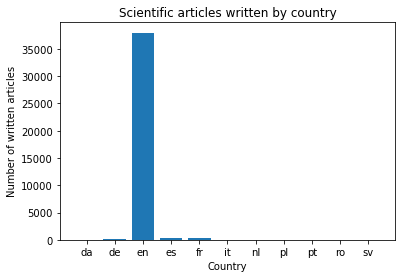

In [45]:
plt.bar(x=list(ag.index), height=ag.body)
plt.title("Scientific articles written by country")
plt.xlabel("Country")
plt.ylabel("Number of written articles")
plt.savefig('images\\N_Scientific_papers_all_langs.png')
plt.show()


<BarContainer object of 9 artists>

Text(0.5, 1.0, 'Scientific articles written by country (no english)')

Text(0.5, 0, 'Country')

Text(0, 0.5, 'Number of written articles')

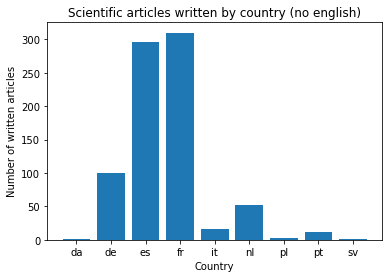

In [46]:
non_english_arts = ag[ag.index.isin(['da', 'de',  'es', 'fr', 'it', 'nl', 'pl', 'pt', 'sv'])]
plt.bar(x=list(non_english_arts.index), height=non_english_arts.body)
plt.title("Scientific articles written by country (no english)")
plt.xlabel("Country")
plt.ylabel("Number of written articles")
plt.savefig('images\\N_Scientific_papers_all_langs_no_en.png')
plt.show()



Spacy Library will be used for text classification
Focus only on english text since is the majority and the one that will bring more context to the classification

In [47]:
articles = articles[articles.language=='en']

In [48]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


# Preprocessing functions implementation

In [49]:
stopwords

<WordListCorpusReader in 'C:\\Users\\admin\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

In [50]:
import spacy
nlp = spacy.load('en_core_web_sm')
punctuations = spacy.lang.punctuation.PUNCT
stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords_cstm = {
    'doi', 'preprint', 'copyright', 'peer', 'reviewed','peerreviewed', 'peerreview', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'elsevier', 'pmc', 'czi', 'www','replc','pk'
}
stopwords = stopwords.union(stopwords_cstm) 
lem = WordNetLemmatizer()
nlp.max_length= 10000000

def cleanup(doc):
    doc = nlp(doc, disable=['parser', 'ner'])
    tokens = [token.lemma_.lower().strip() for token in doc if token.lemma_ != '-PRON-']
    tokens = [token for token in tokens if token not in stopwords and token not in punctuations]
    tokens = ' '.join(tokens)
    texts = tokens
    return texts



def lemmatizer(word,pos): 
    '''
        the lemmatizer takes the 'word' and based on the 'pos' finds the base word of the 'word'
        the pos defines weather to look for a verb, noun, etc. 
    '''
    return lem.lemmatize(word, pos=pos)

def wordStemmer(word): 
    '''
        the wordstemmer, returns the stem of the word 'word'
    '''
    stemmer = SnowballStemmer('english')
    wordstem = stemmer.stem(word)
    return wordstem

def textpreprocessing(text):
    '''
        takes in a 'text',tokenize it, remove stopwords, lemmatize, and finds the stem of each word. 
        Returns the preprocessed text
    '''
    result = []
    for token in word_tokenize(text):
        if token not in stopwords:
            txt = lemmatizer(token, 'v')
            txt = wordStemmer(txt)
            result.append(txt)
    return result
    

# Body text classification

This section of the topic will now focus on preprocessing the text and tokenize.


In [61]:
articles_parquet_file = "articles_parsed.parquet"
if os.path.isfile(articles_parquet_file):
    print('Parquet file found, reading file now...')
    articles = pd.read_parquet(articles_parquet_file)
else:
    print('Parquet file not found, cleaning up data...')
    articles['body_parsed'] = articles['body'].progress_apply(lambda x: cleanup(x))
    articles['body_parsed_word_count'] = articles['body_parsed'].progress_apply(lambda x: len(x.strip().split()))
    articles['p_body'] = articles['body'].progress_map(textpreprocessing)
    articles['p_body'] = articles['p_body'].progress_apply(lambda x: ' '.join(x))
    articles.to_parquet(articles_parquet_file)

Parquet file found, reading file now...


In [58]:
articles.loc[7760]['body']


'associated with different modes of adv delivery especially in immunodeficient hosts and to identify the mechanisms underlying the resulting immunopathology therefore we monitored the biodistribution and metabolism of replicationincompetent ad expressing firefly luciferase adfluc in real time in living mice and rats with or without immunodeficiency the immunodeficient rag  rats were generated previously to resemble immunodeficient human populations   here both rag  mice and rag  rats were used for ad vector safety evaluation like rag  rats rag  mice are defective in the recombination machinery required for the development of both b and t cells but these animals can produce nk cells and no other innate immune cells are affected by the rag  mutation   the immunodeficient rag  mice were more sensitive to ad viral infection than the immunocompetent mice when luminescent signals were detected with the bli method brain tissue sections showed pathological findings only in the rag  mice additi

In [62]:
articles['p_body']

0        vp vp process vp vp virus assembl p p region e...
1        decemb novel coronavirus sarscov identifi wuha...
2        ncov epidem spread china countri februari mass...
3        metagenom sequenc allow direct obtain total ge...
4        infecti bronchiti ib caus infecti bronchiti vi...
                               ...                        
39384    regardless geograph locat respiratori tract in...
39385    experi design test substanc elabor mlc cultur ...
39386    function autonom fashion reloc fuse bacteri en...
39387    tickborn enceph virus tbev human pathogen caus...
39388    min trim polya adaptor read cutadapt version u...
Name: p_body, Length: 37955, dtype: object

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, max_features):
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(text)
    return vectorizer,X

In [64]:
text = articles['p_body'].values
max_features = 4096
vectorizer,X = vectorize(text, max_features)
X.shape

(37955, 4096)

In [65]:
feature_names = vectorizer.get_feature_names()



In [66]:
feature_names

['aa',
 'aav',
 'ab',
 'abdomin',
 'aberr',
 'abi',
 'abil',
 'abl',
 'abnorm',
 'abolish',
 'abort',
 'abrog',
 'abscess',
 'absenc',
 'absent',
 'absolut',
 'absorb',
 'absorpt',
 'abstract',
 'abund',
 'ac',
 'academ',
 'acceler',
 'accept',
 'access',
 'accessori',
 'accid',
 'accommod',
 'accompani',
 'accomplish',
 'accord',
 'account',
 'accumul',
 'accur',
 'accuraci',
 'ace',
 'acet',
 'acetyl',
 'achiev',
 'acid',
 'acknowledg',
 'acquir',
 'acquisit',
 'act',
 'actin',
 'action',
 'activ',
 'actor',
 'actual',
 'acut',
 'ad',
 'adam',
 'adapt',
 'adaptor',
 'add',
 'addit',
 'address',
 'adenosin',
 'adenovirus',
 'adequ',
 'adher',
 'adhes',
 'adjac',
 'adjust',
 'adjuv',
 'administ',
 'administr',
 'admiss',
 'admit',
 'adolesc',
 'adopt',
 'adsorb',
 'adsorpt',
 'adult',
 'adv',
 'advanc',
 'advantag',
 'advers',
 'advic',
 'advis',
 'advoc',
 'ae',
 'aerosol',
 'aeruginosa',
 'aetiolog',
 'af',
 'affect',
 'affin',
 'afford',
 'aforement',
 'africa',
 'african',
 'ag',
 

### Now get the bag of words of the previous vectorizer

In [67]:
frequencies = X.sum(axis=0)

bow = {feature_names[x]:frequencies[0,x] for x in range(len(feature_names))}

bow = {x[0]:x[1] for x in sorted(bow.items(), key=lambda x: x[1],reverse=True)}

In [68]:
keys = np.array(list(bow.keys()))
values = np.array(list(bow.values()))

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 0, 'Top n word')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Frequency of normalized words in whole corpus')

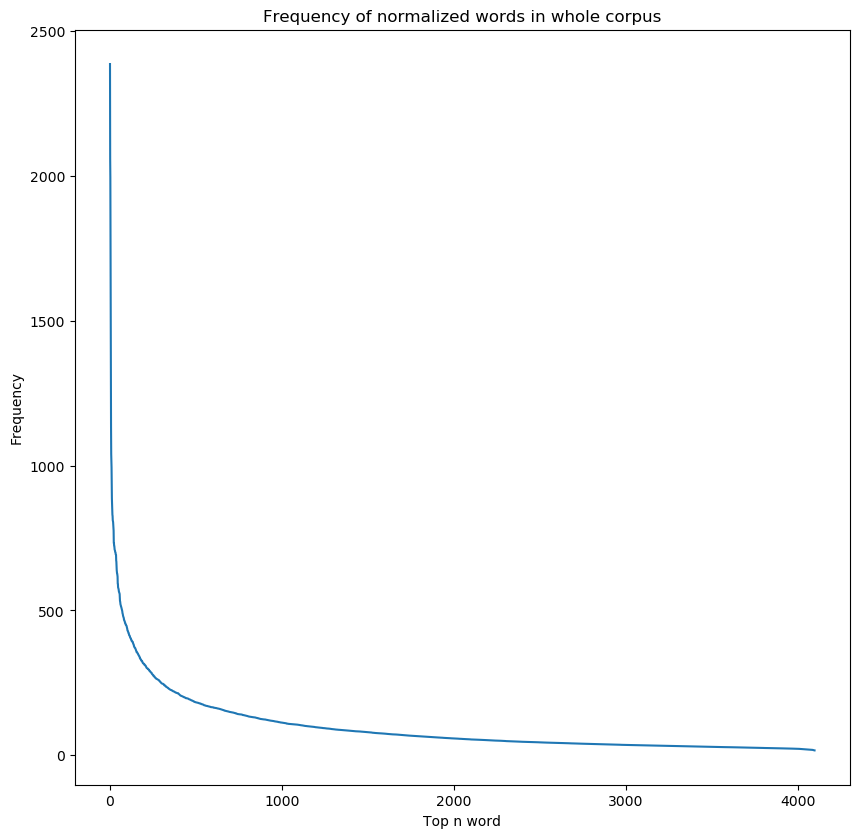

In [69]:
import matplotlib
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
len_vals = len(values)
plt.plot(np.arange(len_vals),values)
plt.xlabel('Top n word')
plt.ylabel('Frequency')
#plt.xlim(0,2000)
#plt.ylim(0,1000)
plt.title('Frequency of normalized words in whole corpus')
plt.savefig('images\\corpus_word_frequency.png')
plt.show()

In [70]:
values[1000]

112.47288059780536

It is visible here that the top 1000 words are aproximately above 112.

### This now can be passed to a Bag Of Words to see the frequency of words for the whole corpus

In [71]:
def plotWordCloud(w, h,max_words,bow,text,colormap,title,file_name=None):
    wordcloud = WordCloud(background_color = 'white', 
                          width=w,height=h, max_words=max_words,
                          relative_scaling=1,normalize_plurals=False,colormap=colormap)
    if text is None:
        wordcloud.generate_from_frequencies(bow)
    else:
        wordcloud.generate_from_text(text)
    plt.figure(figsize=(20, 20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title,fontsize=20)
    if file_name != None:
        plt.savefig(f'images\\{file_name}.png')
    plt.show()

    
def plotWordClouds(n_cols, w, h,max_words,bows,corpus,titles,colormap,file_name=None):
    wordcloud = WordCloud(background_color = 'white',
                          width=w,height=h, max_words=max_words,
                          relative_scaling=1,normalize_plurals=False,colormap=colormap)
    n_charts = len(bows) if corpus is None else len(corpus)
    n_rows = int(round(n_charts // n_cols)) +1
    fig=plt.figure(figsize=(20, 20))
    #for i in tqdm( range(n_charts) ):
    for i in  range(n_charts) :
        if corpus is None:
            wordcloud.generate_from_frequencies(bows[i])
        else:
            wordcloud.generate_from_text(corpus[i])
        fig.add_subplot(n_rows, n_cols, i+1,title=titles[i],xmargin=0,ymargin=0)
        #fig.suptitle(titles[i])
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
    if file_name != None:
        plt.savefig(f'images\\{file_name}.png')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    
    

### Plotting the top 100 words

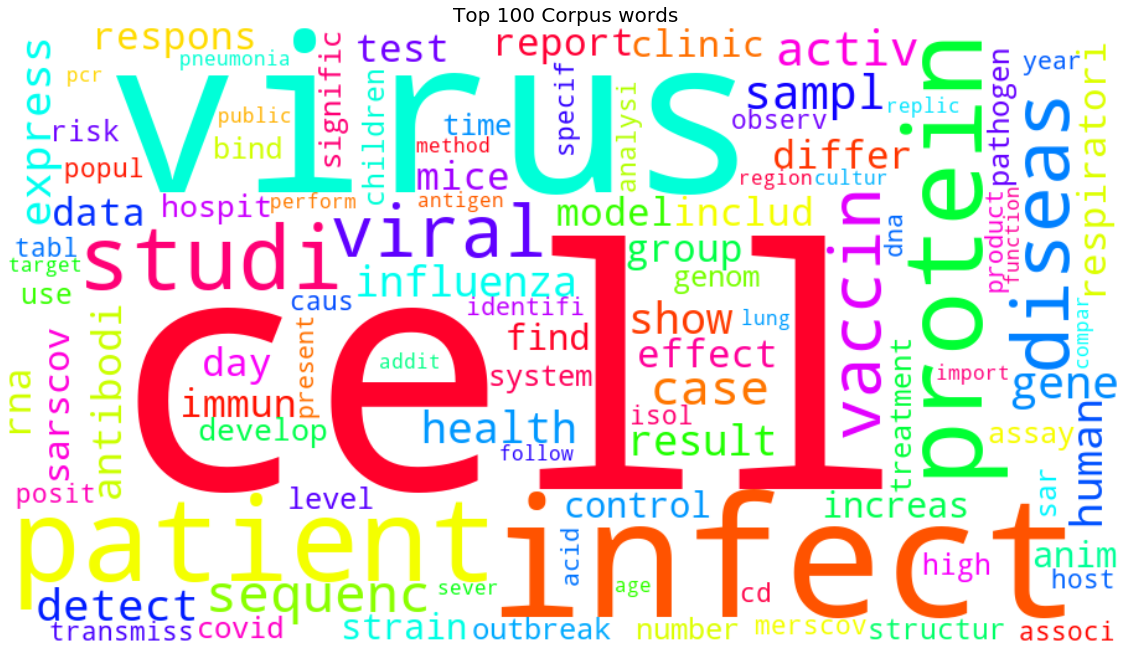

In [72]:
plotWordCloud(900, 500,100,bow,None,matplotlib.cm.hsv,"Top 100 Corpus words","wordcloud_top_100")

### Plotting the top 2000 words

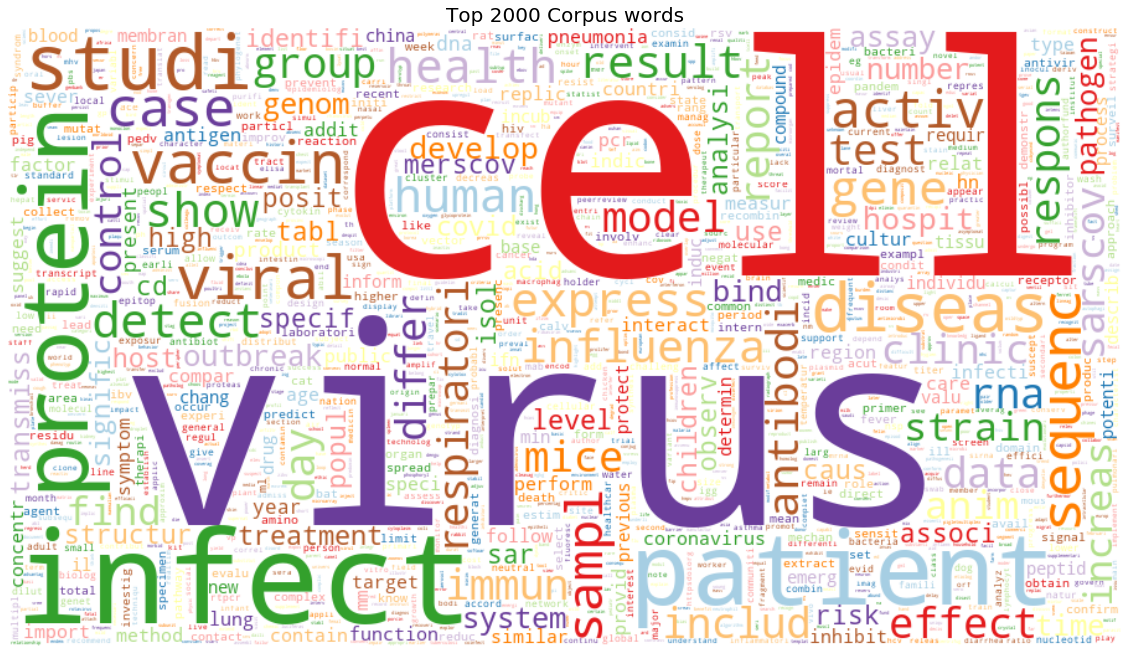

In [73]:
plotWordCloud(900, 500,2000,bow,None,matplotlib.cm.Paired,"Top 2000 Corpus words","wordcloud_top_2000")

# Dimensionality reduction

Entering now in the unsupervised learning field, for this we ought to reduce the dimensionality of the set, PCA Will be used and later on Kmeans to deternine the most suitable number of clusters by the elbow method


In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(37955, 2532)

In [75]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


## Run K-Means N times to find the most suitable number of clusters to classify

In [115]:
# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=14, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=17, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=18, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=19, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=21, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=22, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=23, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=24, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=25, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=26, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=27, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=28, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=29, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=31, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=32, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=33, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=34, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=35, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=36, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=37, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=38, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=39, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=40, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=41, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=42, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=43, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=44, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=45, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=46, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=47, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=48, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=49, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

Text(0.5, 0, 'k')

Text(0, 0.5, 'Distortion')

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

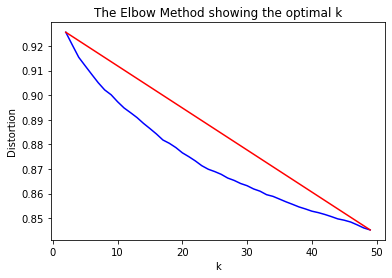

In [116]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method showing the optimal k')
plt.savefig("KMeans_elbow_method.png")
plt.show()

### After running the metthod it is possible to see that the number of clusters can be suitable in 23-25. 23 clusters are selected

In [89]:
gc.collect()

20

In [85]:
k=23
y_pred = articles['predicted']

In [105]:
kmeans = KMeans(n_clusters=k, random_state=42,verbose=3)
y_pred = kmeans.fit_predict(X_reduced)
articles['predicted'] = y_pred
articles.to_parquet(articles_file)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 30389.271802481442
start iteration
done sorting
end inner loop
Iteration 1, inertia 29654.983958384157
start iteration
done sorting
end inner loop
Iteration 2, inertia 29402.103736051267
start iteration
done sorting
end inner loop
Iteration 3, inertia 29294.46998656695
start iteration
done sorting
end inner loop
Iteration 4, inertia 29255.239601164518
start iteration
done sorting
end inner loop
Iteration 5, inertia 29231.122408060986
start iteration
done sorting
end inner loop
Iteration 6, inertia 29210.411479645645
start iteration
done sorting
end inner loop
Iteration 7, inertia 29196.738319619137
start iteration
done sorting
end inner loop
Iteration 8, inertia 29191.006762119796
start iteration
done sorting
end inner loop
Iteration 9, inertia 29185.62778513883
start iteration
done sorting
end inner loop
Iteration 10, inertia 29180.31769878508
start iteration
done sorting
end inner loop
Iteration 

Iteration 39, inertia 29247.35112596364
start iteration
done sorting
end inner loop
Iteration 40, inertia 29247.050276300022
start iteration
done sorting
end inner loop
Iteration 41, inertia 29246.685490049895
start iteration
done sorting
end inner loop
Iteration 42, inertia 29246.205513507743
start iteration
done sorting
end inner loop
Iteration 43, inertia 29245.67890151866
start iteration
done sorting
end inner loop
Iteration 44, inertia 29245.051531079658
start iteration
done sorting
end inner loop
Iteration 45, inertia 29243.510781529636
start iteration
done sorting
end inner loop
Iteration 46, inertia 29240.78506647892
start iteration
done sorting
end inner loop
Iteration 47, inertia 29236.922794259186
start iteration
done sorting
end inner loop
Iteration 48, inertia 29232.458166968157
start iteration
done sorting
end inner loop
Iteration 49, inertia 29228.05573239188
start iteration
done sorting
end inner loop
Iteration 50, inertia 29224.558876886622
start iteration
done sorting

Iteration 59, inertia 29148.85141742502
start iteration
done sorting
end inner loop
Iteration 60, inertia 29148.849088444673
start iteration
done sorting
end inner loop
Iteration 61, inertia 29148.841415025592
start iteration
done sorting
end inner loop
Iteration 62, inertia 29148.834376237195
start iteration
done sorting
end inner loop
Iteration 63, inertia 29148.830704467186
start iteration
done sorting
end inner loop
Iteration 64, inertia 29148.829007283442
start iteration
done sorting
end inner loop
Iteration 65, inertia 29148.829007283442
center shift 0.000000e+00 within tolerance 3.468178e-08
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 30379.348139459365
start iteration
done sorting
end inner loop
Iteration 1, inertia 29714.24712032101
start iteration
done sorting
end inner loop
Iteration 2, inertia 29551.946493636347
start iteration
done sorting
end inner loop
Iteration 3, inertia 29444.358220592123
start iteration
done sorting
end in

KeyboardInterrupt: 

In [77]:
X_embedded_file_name = 'x_embedded.pickle'
X_embedded = read_pickle(X_embedded_file_name)
X_embedded

array([[-34.975517,  -9.834972],
       [-22.882057, -46.208824],
       [-19.119837, -44.35848 ],
       ...,
       [-20.262318,  31.111794],
       [ -8.185811,  46.814056],
       [ 16.132051,   5.904731]], dtype=float32)

In [93]:
if X_embedded is None:
    from sklearn.manifold import TSNE
    tsne = TSNE(verbose=3, perplexity=100, random_state=42)
    X_embedded = tsne.fit_transform(X.toarray())
    write_pickle(X_embedded,)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 37955 samples in 82.401s...
[t-SNE] Computed neighbors for 37955 samples in 8197.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 37955
[t-SNE] Computed conditional probabilities for sample 2000 / 37955
[t-SNE] Computed conditional probabilities for sample 3000 / 37955
[t-SNE] Computed conditional probabilities for sample 4000 / 37955
[t-SNE] Computed conditional probabilities for sample 5000 / 37955
[t-SNE] Computed conditional probabilities for sample 6000 / 37955
[t-SNE] Computed conditional probabilities for sample 7000 / 37955
[t-SNE] Computed conditional probabilities for sample 8000 / 37955
[t-SNE] Computed conditional probabilities for sample 9000 / 37955
[t-SNE] Computed conditional probabilities for sample 10000 / 37955
[t-SNE] Computed conditional probabilities for sample 11000 / 37955
[t-SNE] Computed conditional probabilities for sample 12000 / 37955
[t-SNE] Computed conditional probabilities fo

Saving picled Articles

In [78]:
gc.collect()

68388

In [79]:
X_embedded.shape

(37955, 2)

### Now is possible to have a general overview of the resulted clusters

Text(0.5, 1.0, 't-SNE unlabelled')

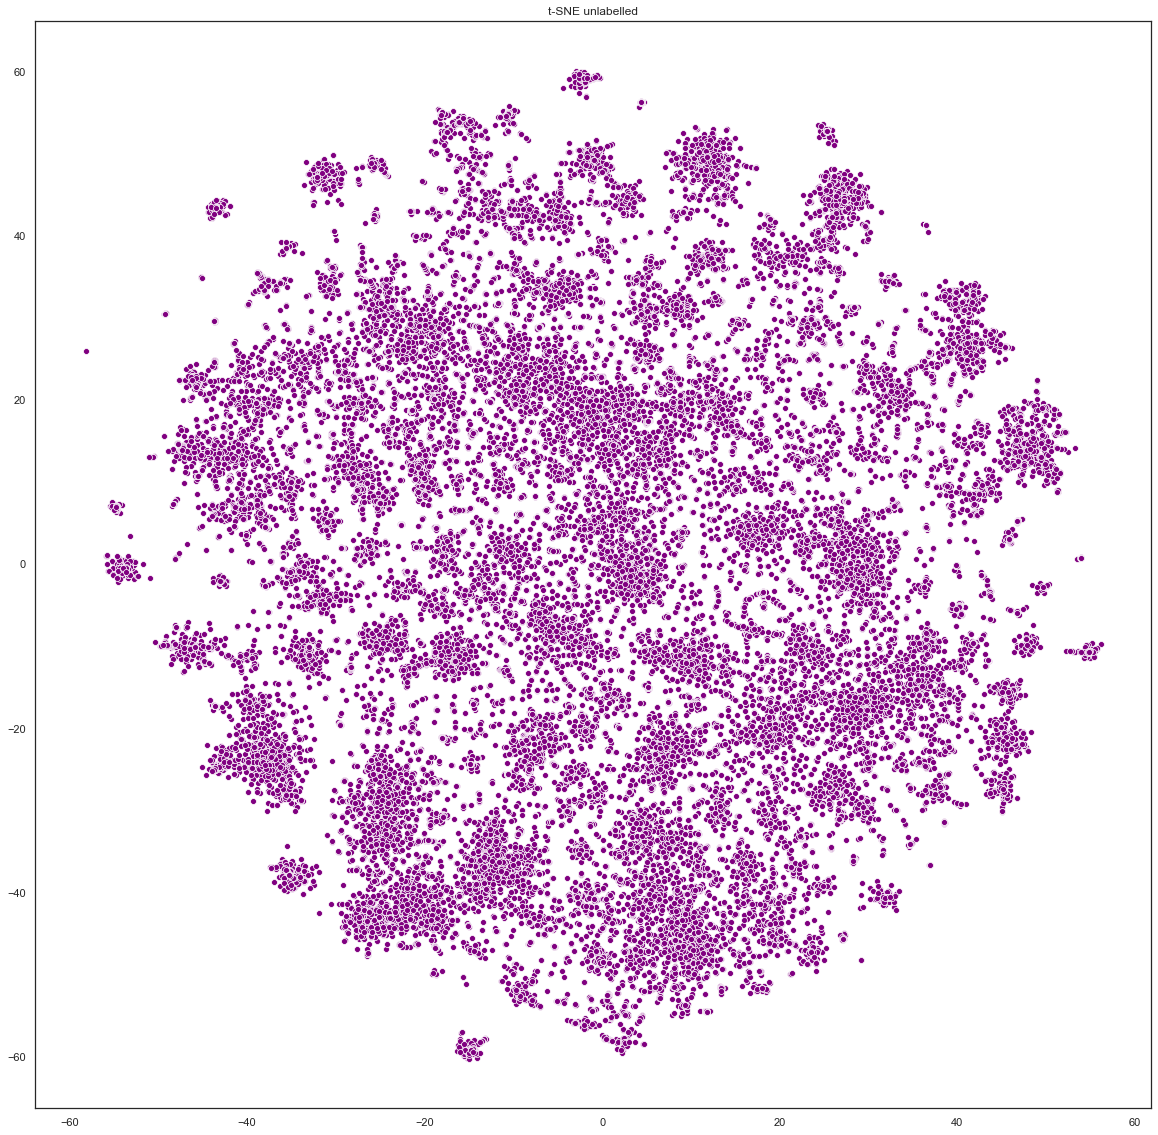

In [80]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,20)})
sns.set_style("white")
sns.scatterplot(X_embedded[:,0], X_embedded[:,1],color='purple')
plt.title('t-SNE unlabelled')
plt.savefig("COV-19_t-sne_unlabelled.png")
plt.show()

Text(0.5, 1.0, 't-SNE with Kmeans Labels')

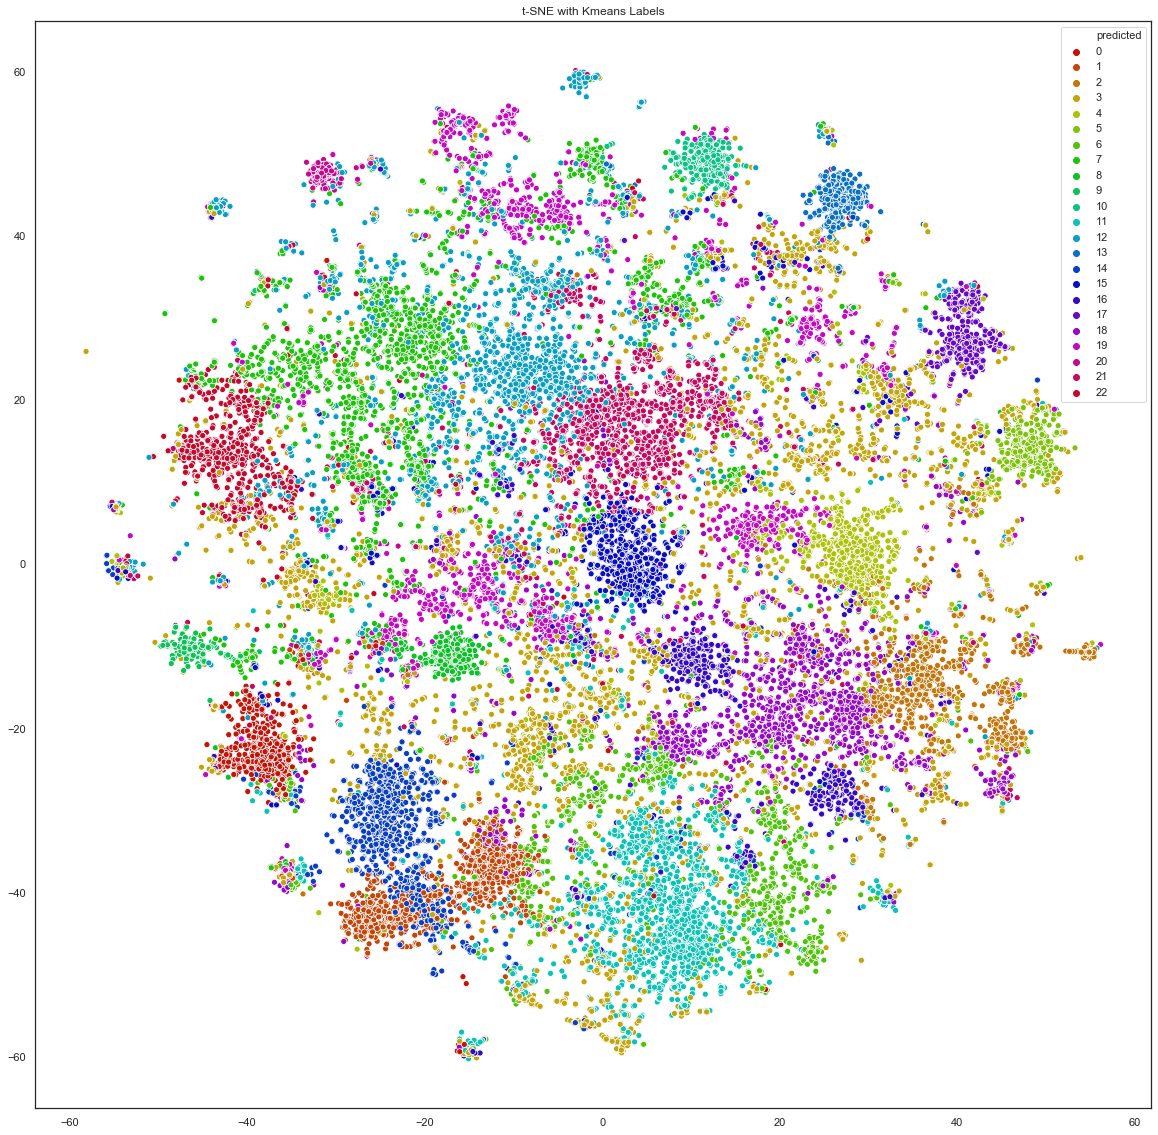

In [86]:
palette = sns.hls_palette(k, l=.4, s=.9)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [87]:
gc.collect()
corpus = []
n_clusters = list(range(k)) 
for i in n_clusters:
    text_set = ' '.join(articles[y_pred==i]['p_body'])
    corpus.append(text_set)
titles = [f"CLUSTER {i+1}"  for i in n_clusters]    

74

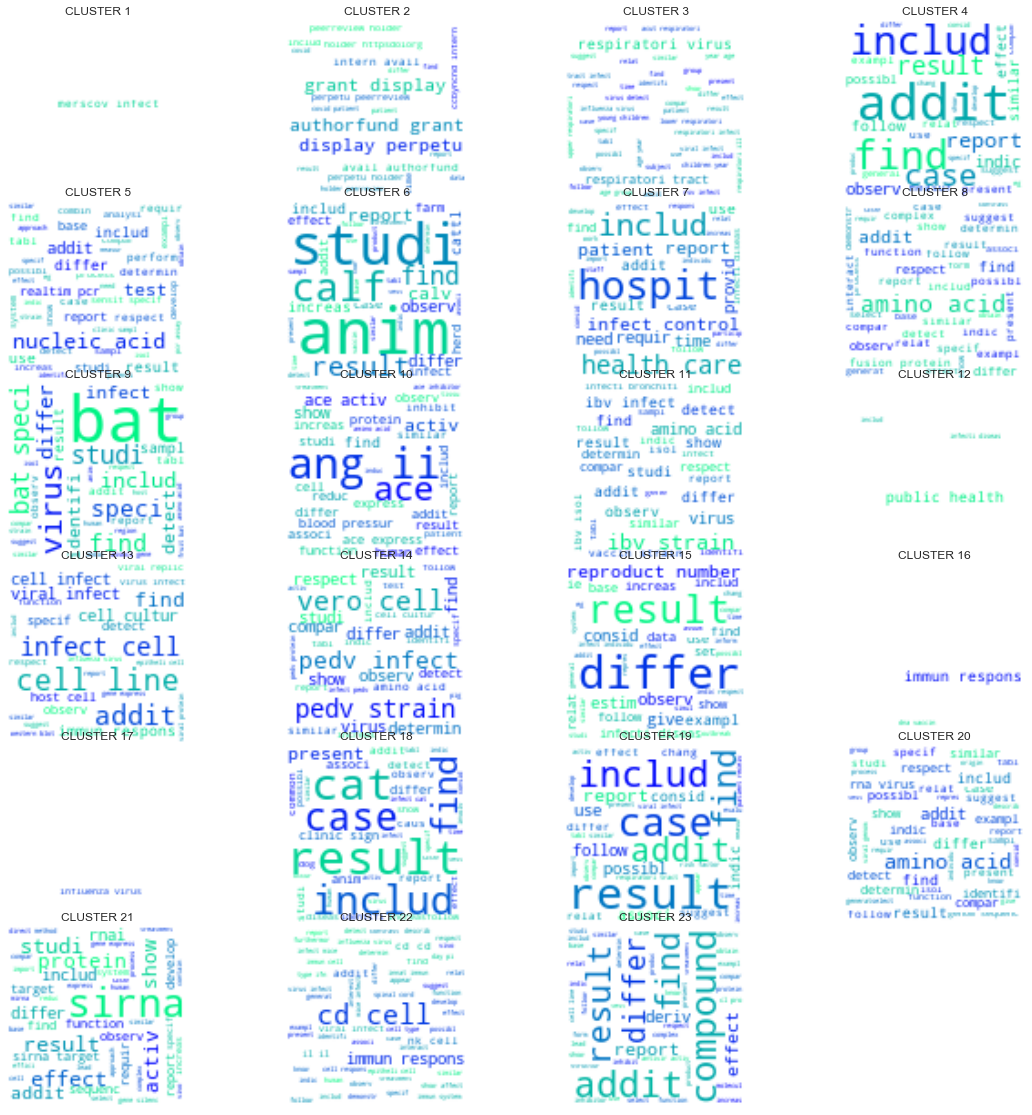

In [88]:
plotWordClouds(4, 100, 100,100,None,corpus,titles,matplotlib.cm.winter,'wordcloud_top_100_all')

There seems to be something wrong in 

In [138]:
%pip install bokeh

  Created wheel for bokeh: filename=bokeh-2.0.2-py3-none-any.whl size=9072545 sha256=1fae67b1bf6ef9c124ef3560d02016ecb76285f520534afe7ebb1ddb93532c86
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\d5\c1\d7\1409f68d9b4c0a3e648bf2926210e3a760322b3dccaff93e06
Successfully built bokeh
Note: you may need to restart the kernel to use updated packages.


In [97]:
from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
from bokeh.models import CategoricalColorMapper
from bokeh.models import HoverTool
from bokeh.io import output_notebook, output_file

In [98]:
plot = figure(tools='pan,box_zoom')
plot.circle(X_embedded[:,0], X_embedded[:,1])
#output_file('clusters_interactive.html')
output_notebook()
show(plot)


#, hue=y_pred

GlyphRenderer(id='1904', ...)

Loading BokehJS ...

In [144]:
y_pred

array([19,  1, 14, ...,  7, 19, 19])

In [153]:
len(palette[0:k])

23

In [159]:
palette[0]

(0.76, 0.08320000000000004, 0.040000000000000036)